# Implementing Real-Time Bitcoin Price Analysis with Spark SQL

This notebook shows an example of Real-Time Bitcoin Price Analysing using the Spark SQL. This example will demonstrate:
- Loading data into views in real-time
- Applying basic and complex SQL queries for time-series analysis
    - Aggregation Functions
    - Determining Thresholds
- Identifying signficant spikes and drops in price by hour
- Extrapolating/Predicting price for the next hour, day, and month based on past trends
- Creating time series, box and whisker, and histogram plots for visualization

# Getting Set Up - Libraries and Data
First we will load and create view for the price data for the past year at the daily level and the price data for the past 90 days at the hourly level, which will have automatic updates every hour. Data is loaded using the BitcoinDataHandler class which can be found in sparkSQL_utils.py.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
#Import libraries.
import os
import pyspark.sql
import sparkSQL_utils
import matplotlib.pyplot as plt
import pandas as pd
import threading
import pyspark.sql.functions as F

In [3]:
#Create a simple Spark session in the notebook.
spark = pyspark.sql.SparkSession.builder \
    .appName("BitcoinPriceAnalysis") \
    .config("spark.sql.legacy.createHiveTableByDefault", "false") \
    .config("spark.sql.session.timeZone", "UTC") \
    .config("spark.driver.extraJavaOptions", "--add-opens java.base/java.nio=ALL-UNNAMED") \
    .config("spark.executor.extraJavaOptions", "--add-opens java.base/java.nio=ALL-UNNAMED") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

#Create & initialize instance of the BitcoinDataHandler class.
handler = sparkSQL_utils.BitcoinDataHandler(spark)

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/05/16 16:05:47 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
#Load historical price data. This creates the view btc_prices (up to 1 year) at the daily level.
handler.load_data(total_days=365, currency="usd", view_name="btc_prices", data_path="btc_prices_daily")

Cleared view btc_prices.
Fetching Bitcoin data.


Created view btc_prices and updated with 365 rows.


In [5]:
#Create btc_prices_hourly_auto and start the automatic background updates for new data. Data is updated every hour.
thread = threading.Thread(
    target=handler.start_real_time_update,
    kwargs={"curr": "usd", "days": 90, "vw_nm":"btc_prices_hourly_auto", "path":"btc_prices_hourly"}
)
thread.daemon = True
thread.start()

Cleared view btc_prices_hourly_auto.
Fetching Bitcoin data.
Created view btc_prices_hourly_auto and updated with 2158 rows.
Fetching new data.
Added following new record(s):
+------------------+----------------+-------------------+
|             price|       timestamp|         price_date|
+------------------+----------------+-------------------+
|104068.97915372228|1.747414603058E9|2025-05-16 16:56:43|
|104127.19052754015|1.747415134533E9|2025-05-16 17:05:34|
+------------------+----------------+-------------------+

None
Fetching new data.
Added following new record(s):
+------------------+----------------+-------------------+
|             price|       timestamp|         price_date|
+------------------+----------------+-------------------+
|103976.81475435526|1.747418455375E9|2025-05-16 18:00:55|
+------------------+----------------+-------------------+

None


In [6]:
#Run to stop real time updates at hourly level.
#handler.stop_real_time_update()

In [7]:
#Confirm data is populated in the views.
spark.sql("SELECT * FROM btc_prices ORDER BY price_date DESC LIMIT 5").show()
spark.sql("SELECT * FROM btc_prices_hourly_auto ORDER BY price_date DESC LIMIT 5").show()

+------------------+-----------+----------+
|             price|  timestamp|price_date|
+------------------+-----------+----------+
|103708.85136423641|1.7473536E9|2025-05-16|
|103594.42575090709|1.7472672E9|2025-05-15|
|104184.49039270742|1.7471808E9|2025-05-14|
| 102876.8304286011|1.7470944E9|2025-05-13|
|  103994.061616746| 1.747008E9|2025-05-12|
+------------------+-----------+----------+

+------------------+----------------+-------------------+
|             price|       timestamp|         price_date|
+------------------+----------------+-------------------+
|103647.16205373578| 1.74740784187E9|2025-05-16 15:04:01|
|103878.14561854265|1.747404300515E9|2025-05-16 14:05:00|
|103626.44459045639|1.747400693085E9|2025-05-16 13:04:53|
|103672.28959796879|1.747396869062E9|2025-05-16 12:01:09|
|103870.40503140159|1.747393698896E9|2025-05-16 11:08:18|
+------------------+----------------+-------------------+



# Understanding the data available
Next, we will explore the historical daily and real-time hourly data and determine the range, amount, and any potential missing data.

## Price historical data

In [8]:
#Confirm that the view contains the past one year of price data.
spark.sql("""
    SELECT COUNT(distinct price_date) as num_distinct_dates, 
           MIN(price_date) as erlst_price_dt, 
           MAX(price_date) as ltst_price_dt 
    FROM btc_prices
""").show()

#Check how many distinct data points (prices) are available per date.
spark.sql("SELECT distinct count(*) as num_prices_per_day FROM btc_prices GROUP BY price_date").show()

+------------------+--------------+-------------+
|num_distinct_dates|erlst_price_dt|ltst_price_dt|
+------------------+--------------+-------------+
|               365|    2024-05-17|   2025-05-16|
+------------------+--------------+-------------+

+------------------+
|num_prices_per_day|
+------------------+
|                 1|
+------------------+



In [9]:
#Check if there are any missing (null) or zero values.
spark.sql("SELECT * FROM btc_prices where price_date IN (null, 0) or price IN (null, 0)").show()

+-----+---------+----------+
|price|timestamp|price_date|
+-----+---------+----------+
+-----+---------+----------+



## Hourly Real-Time Data

In [10]:
#Confirm that the view contains the past three months of price data.
spark.sql("""
    SELECT count(distinct DATE_FORMAT(price_date, 'yyyy-MM-DD')) as num_distinct_dates, 
           MIN(price_date) as erlst_price_dt, 
           MAX(price_date) as ltst_price_dt 
    FROM btc_prices_hourly_auto
""").show()

#Check how many distinct data points (prices) are available per date.
spark.sql("""
    SELECT distinct count(price) as num_prices_per_day 
    FROM btc_prices_hourly_auto 
    GROUP BY DATE_FORMAT(price_date, 'yyyy-MM-dd')
""").show()

#Check how many distinct dates have fewer than 24 prices.
spark.sql("""
    SELECT DATE_FORMAT(price_date, 'yyyy-MM-dd') as formatted_price_date,
           COUNT(*) as num_prices_per_day 
    FROM btc_prices_hourly_auto
    GROUP BY DATE_FORMAT(price_date, 'yyyy-MM-dd')
    HAVING count(price) < 24
""").show()


+------------------+-------------------+-------------------+
|num_distinct_dates|     erlst_price_dt|      ltst_price_dt|
+------------------+-------------------+-------------------+
|                91|2025-02-15 16:09:10|2025-05-16 15:04:01|
+------------------+-------------------+-------------------+

+------------------+
|num_prices_per_day|
+------------------+
|                 8|
|                23|
|                16|
|                24|
+------------------+

+--------------------+------------------+
|formatted_price_date|num_prices_per_day|
+--------------------+------------------+
|          2025-05-09|                23|
|          2025-02-15|                 8|
|          2025-03-06|                23|
|          2025-05-16|                16|
+--------------------+------------------+



# Time-Series Analysis: Prices Over the Past Year
Here, we will use Spark SQL queries and aggregation functions to calculate descriptive statistics for the dataset, and determine if the price of Bitcoin has changed in the past year, by how much, and if the change is consistent or oscillating.

In [11]:
#Calculate descriptive statistcs for each month in the past year.
monthly_price_stats_df = spark.sql("""
    SELECT mth_yr, AVG(price) as avg_price, 
           MIN(price) as min_price, 
           MAX(price) as max_price,
           MAX(price)-MIN(price) as range_in_price
    FROM (SELECT *,DATE_FORMAT(price_date, 'yyyy-MM') as mth_yr FROM btc_prices)
    GROUP BY mth_yr
    ORDER BY mth_yr
""")
monthly_price_stats_df.show()

+-------+------------------+------------------+------------------+------------------+
| mth_yr|         avg_price|         min_price|         max_price|    range_in_price|
+-------+------------------+------------------+------------------+------------------+
|2024-05| 68275.86396894426|65260.879803346186| 71430.29700215145| 6169.417198805262|
|2024-06| 66053.75856626955| 60317.09697945116| 71184.59943059199|10867.502451140826|
|2024-07| 62761.60804689704|  55880.3753776708|  68242.2474440493|12361.872066378492|
|2024-08| 60107.96853052593| 53956.26184159744| 65357.52960767435|11401.267766076904|
|2024-09|60210.028723899035| 53923.35611071905| 65934.10709441357|12010.750983694525|
|2024-10| 65360.04001652121| 60195.18073772453| 72781.11308158132|12585.932343856795|
|2024-11| 85687.36014199888| 67793.29782704762| 98927.49494553401|31134.197118486394|
|2024-12| 98380.90778199893| 92627.28213113277|106074.10723541168|13446.825104278905|
|2025-01| 99696.06252905859| 92376.27578346101| 106182

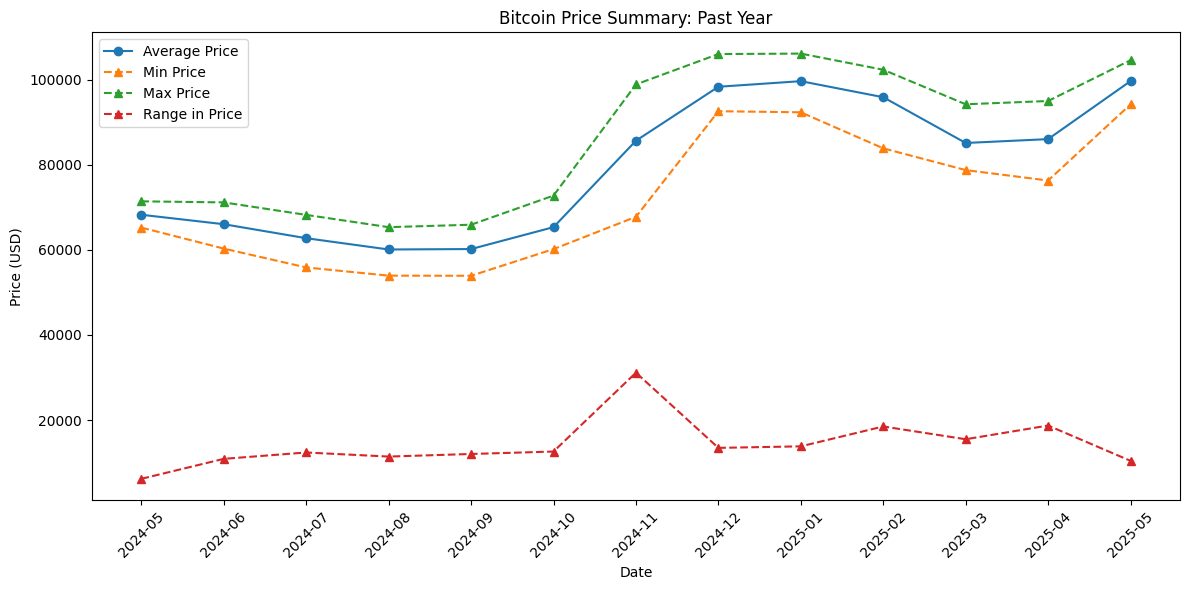

In [12]:
#Plot the calculated descriptive statistcs for each month in the past year.
monthly_price_stats_df = monthly_price_stats_df.toPandas()

plt.figure(figsize=(12, 6))
plt.plot(monthly_price_stats_df["mth_yr"], monthly_price_stats_df["avg_price"], label="Average Price", marker='o')
plt.plot(monthly_price_stats_df["mth_yr"], monthly_price_stats_df["min_price"], label="Min Price", linestyle='--', marker='^')
plt.plot(monthly_price_stats_df["mth_yr"], monthly_price_stats_df["max_price"], label="Max Price", linestyle='--', marker='^')
plt.plot(monthly_price_stats_df["mth_yr"], monthly_price_stats_df["range_in_price"], label="Range in Price", linestyle='--', marker='^')
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Summary: Past Year")
plt.legend()
plt.tight_layout()
plt.show()

# Time-Series Analysis: Hourly Prices Over Past 90 Days
Similarly, we will leverage Spark SQL and compute descriptive statistics for the hourly-level dataset and visualize the trend in the Bitcoin prices.

In [13]:
#Calculate descriptive statistcs for each date in the 90 days.
daily_price_stats_df = spark.sql("""
    SELECT date, AVG(price) as avg_price, 
           MIN(price) as min_price, 
           MAX(price) as max_price,
           MAX(price)-MIN(price) as range_in_price
    FROM (SELECT * ,DATE_FORMAT(price_date, 'yyyy-MM-dd') as date FROM btc_prices_hourly_auto)
    GROUP BY date
    ORDER BY date
""")
daily_price_stats_df.show()

+----------+-----------------+-----------------+-----------------+------------------+
|      date|        avg_price|        min_price|        max_price|    range_in_price|
+----------+-----------------+-----------------+-----------------+------------------+
|2025-02-15|97579.56236295107|97422.02899712167|97709.33332248866|287.30432536698936|
|2025-02-16|97240.34965349373|96820.88754034557|97670.43504008041| 849.5474997348356|
|2025-02-17|96083.79954588367|95305.81471590063|96825.39185696325|1519.5771410626185|
|2025-02-18|95363.12481943234|93902.52254777655|96283.17216937791| 2380.649621601362|
|2025-02-19|95873.20120105369|95176.94369782117|96540.84301900618| 1363.899321185003|
|2025-02-20|97415.03660912895| 96631.9764747056| 98519.0592307595|1887.0827560539037|
|2025-02-21|97768.37823843183|94909.23471393716|99244.09049710589| 4334.855783168736|
|2025-02-22|96467.25297301084|96135.15541305285|96857.71626951931| 722.5608564664581|
|2025-02-23|96080.57547594431|95425.30528594145|96652.

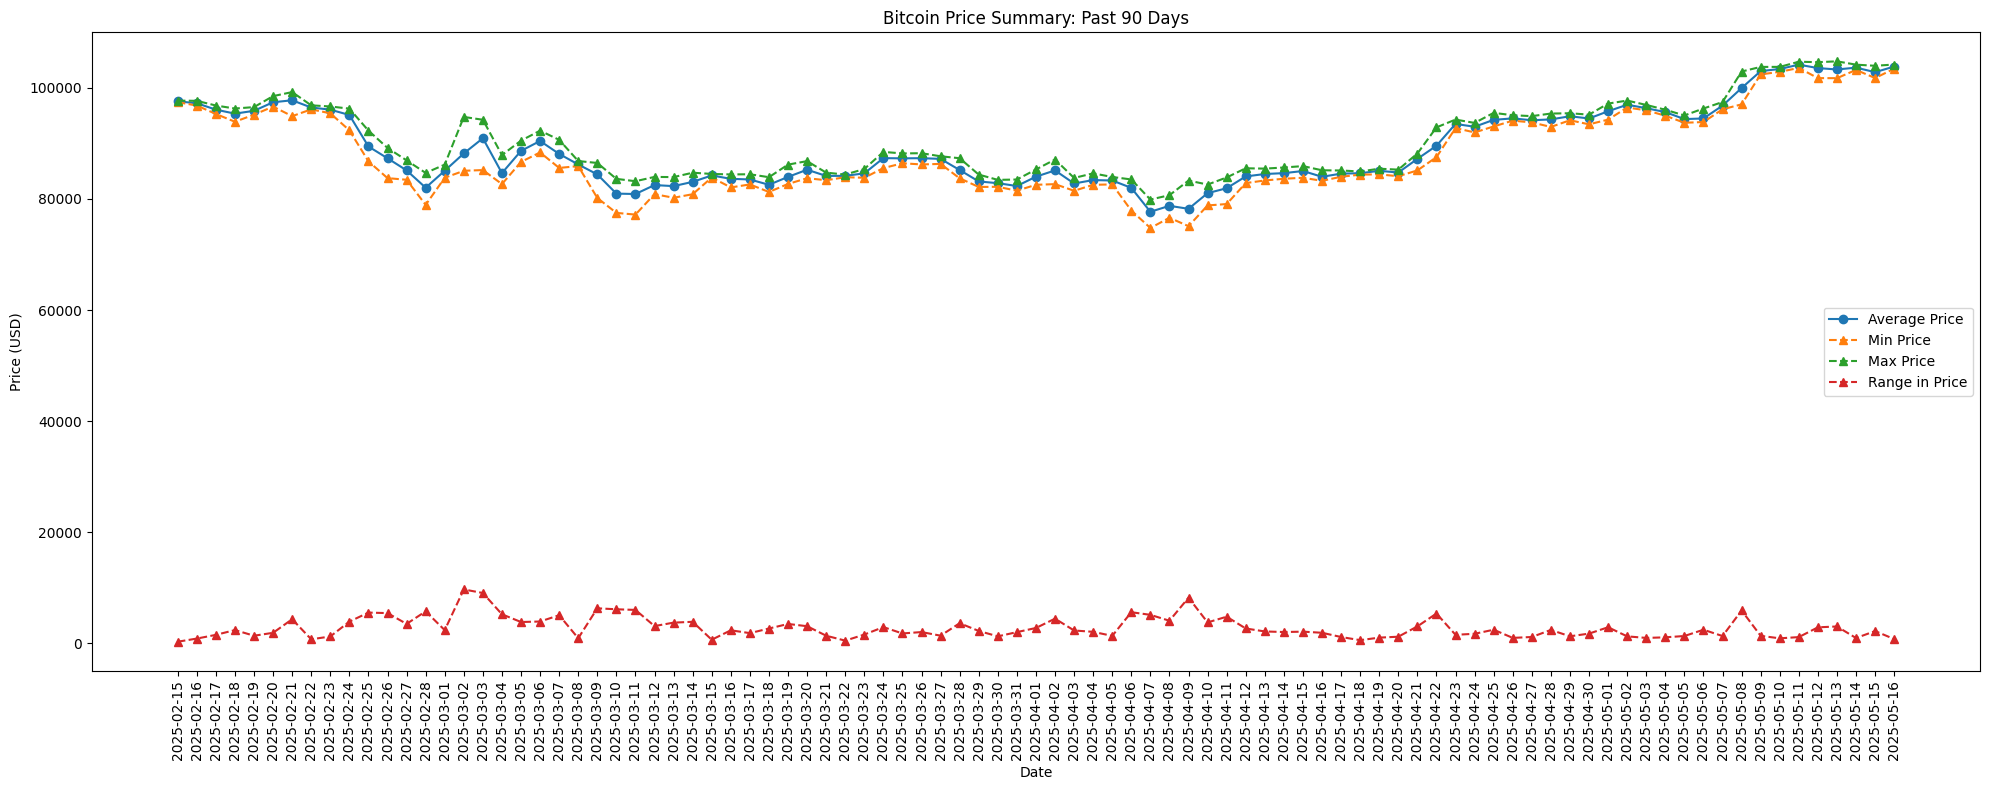

In [14]:
#Plot the calculated descriptive statistcs for each month in the past year.
daily_price_stats_df = daily_price_stats_df.toPandas()

plt.figure(figsize=(20, 8))
plt.plot(daily_price_stats_df["date"], daily_price_stats_df["avg_price"], label="Average Price", marker='o')
plt.plot(daily_price_stats_df["date"], daily_price_stats_df["min_price"], label="Min Price", linestyle='--', marker='^')
plt.plot(daily_price_stats_df["date"], daily_price_stats_df["max_price"], label="Max Price", linestyle='--', marker='^')
plt.plot(daily_price_stats_df["date"], daily_price_stats_df["range_in_price"], label="Range in Price", linestyle='--', marker='^')
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Summary: Past 90 Days")
plt.legend()
plt.tight_layout()
plt.show()

In [15]:
#Calculate the average range in price on one day.
spark.sql("""
    SELECT AVG(range_in_price) as avg_range_bitcoin_price
    FROM(  
         SELECT DATE_FORMAT(price_date, 'yyyy-MM-dd'), 
                MAX(price)-MIN(price) as range_in_price 
         FROM btc_prices_hourly_auto
         GROUP BY DATE_FORMAT(price_date, 'yyyy-MM-dd')
        )
""").show()

+-----------------------+
|avg_range_bitcoin_price|
+-----------------------+
|      2787.134502380543|
+-----------------------+



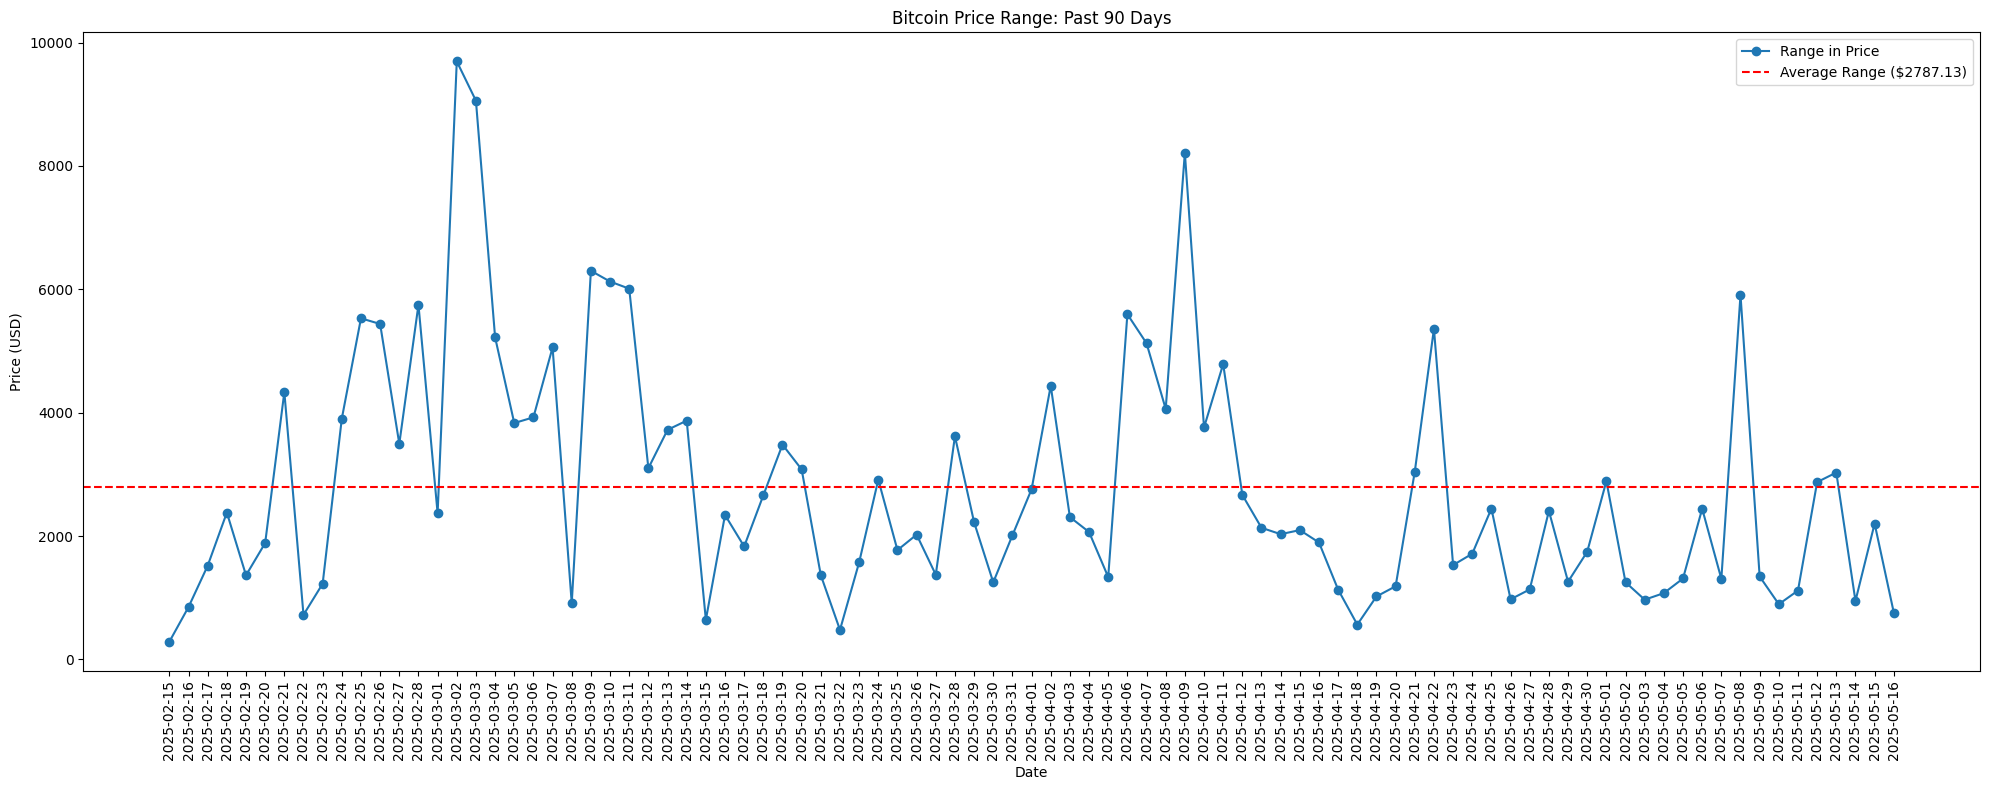

In [16]:
# Calculate average range from above using Dataframe API and create line plot showing the average ranges.
avg_range = daily_price_stats_df['range_in_price'].mean()

#Plot the calculated descriptive statistcs for each day in the time period.
plt.figure(figsize=(20, 8))
plt.plot(daily_price_stats_df["date"], daily_price_stats_df["range_in_price"], label="Range in Price", marker='o')
plt.axhline(y=avg_range, color='red', linestyle='--', label=f'Average Range (${avg_range:.2f})')
plt.xticks(rotation=90)
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.title("Bitcoin Price Range: Past 90 Days")
plt.legend()
plt.tight_layout()
plt.show()

# Anomalies - Spikes/Drops in Past 90 Days
We'll use Spark SQL queries to determine how much the price changes within an hour and if there any anonomalies: spikes or drops as determined by absolute value of average percent of change as a threshold and identifying any outliers using the IQR method. 

## Average Percent Change as a Threshold 

In this section, we will calculate the price change, percent change, and absolute average percent change (to account for increase and decrease in price). We will view the results in a table form and visualize via a line plot where we add the threshold(s) as a line.

In [17]:
#Query to identify the price and price percent changes at the hourly level.
spark.sql("""
    SELECT *
    FROM (
          SELECT *,
                 price - LAG(price) OVER (PARTITION BY DATE_FORMAT(price_date, 'yyyy-MM-dd') ORDER BY price_date) AS price_change,
                 (price - LAG(price) OVER (PARTITION BY DATE_FORMAT(price_date, 'yyyy-MM-dd') ORDER BY price_date)) / LAG(price) OVER (PARTITION BY DATE_FORMAT(price_date, 'yyyy-MM-dd') ORDER BY price_date) * 100 AS percent_change
          FROM btc_prices_hourly_auto
         )
    ORDER BY price_change DESC
""").show()

+------------------+----------------+-------------------+------------------+------------------+
|             price|       timestamp|         price_date|      price_change|    percent_change|
+------------------+----------------+-------------------+------------------+------------------+
| 91378.26201151186|1.740934947716E9|2025-03-02 17:02:27|3932.7189266954665|  4.49733489891073|
| 81841.29813646984|1.744221878303E9|2025-04-09 18:04:38|3746.2175800681725| 4.796995602511207|
| 94183.67640464348|1.740938497716E9|2025-03-02 18:01:37| 2805.414393131621| 3.070111349653591|
| 88065.84191323837|1.741313093352E9|2025-03-07 02:04:53|2475.3754704684543|2.8921158784940313|
|  87445.5430848164|1.740931496774E9|2025-03-02 16:04:56| 2370.352090910106| 2.786184859790545|
|101783.94854609821|1.746720115878E9|2025-05-08 16:01:55|1900.6440467530629|1.9028646041296358|
| 79080.26510244102|1.741658616428E9|2025-03-11 02:03:36|1893.3387875181797|2.4529267816590505|
| 83185.92996285958|1.741720114019E9|202

In [18]:
#Update query from above to also include previous timestamp information, and display percent change.
#Select rows with absolute value of percent change >= absolute value of average percent change in the entire dataset.
spark.sql("""
    WITH formatted_rows as(
        SELECT *, DATE_FORMAT(price_date, 'yyyy-MM-dd') as date
        FROM btc_prices_hourly_auto
    ), previous_ts as (
        SELECT *, 
               LAG(price) OVER (PARTITION BY date ORDER BY price_date) as prev_price,
               LAG(price_date) OVER (PARTITION BY date ORDER BY price_date) as prev_price_date
        FROM formatted_rows
    ), price_changes as (
        SELECT *, 
               price-prev_price as price_change,
               (price-prev_price)/prev_price * 100 as percent_change
        FROM previous_ts
    ), avg_change as (
        SELECT AVG(ABS(percent_change)) AS abs_avg_change_prcnt
        FROM price_changes
    ), final as (
        SELECT p.*, a.abs_avg_change_prcnt
        FROM price_changes p
        CROSS JOIN avg_change a
    )
    SELECT price_date, 
           CAST(price as DECIMAL(10,2)), 
           prev_price_date, 
           CAST(prev_price as DECIMAL(10,2)), 
           CAST(price_change as DECIMAL(8,2)), 
           CAST(percent_change as DECIMAL(8,2)), 
           CAST(abs_avg_change_prcnt as DECIMAL(8,2))
    FROM final 
    WHERE abs(percent_change) >= abs_avg_change_prcnt
    ORDER BY abs(percent_change) DESC
""").show()

+-------------------+--------+-------------------+----------+------------+--------------+--------------------+
|         price_date|   price|    prev_price_date|prev_price|price_change|percent_change|abs_avg_change_prcnt|
+-------------------+--------+-------------------+----------+------------+--------------+--------------------+
|2025-03-07 01:04:38|85590.47|2025-03-07 00:04:45|  89924.21|    -4333.75|         -4.82|                0.36|
|2025-04-09 18:04:38|81841.30|2025-04-09 17:05:55|  78095.08|     3746.22|          4.80|                0.36|
|2025-03-02 17:02:27|91378.26|2025-03-02 16:04:56|  87445.54|     3932.72|          4.50|                0.36|
|2025-03-03 15:09:47|89948.47|2025-03-03 14:00:29|  93288.33|    -3339.86|         -3.58|                0.36|
|2025-03-10 14:08:27|80589.75|2025-03-10 13:04:51|  83263.61|    -2673.86|         -3.21|                0.36|
|2025-03-03 19:09:53|87491.42|2025-03-03 18:00:27|  90362.03|    -2870.61|         -3.18|                0.36|
|

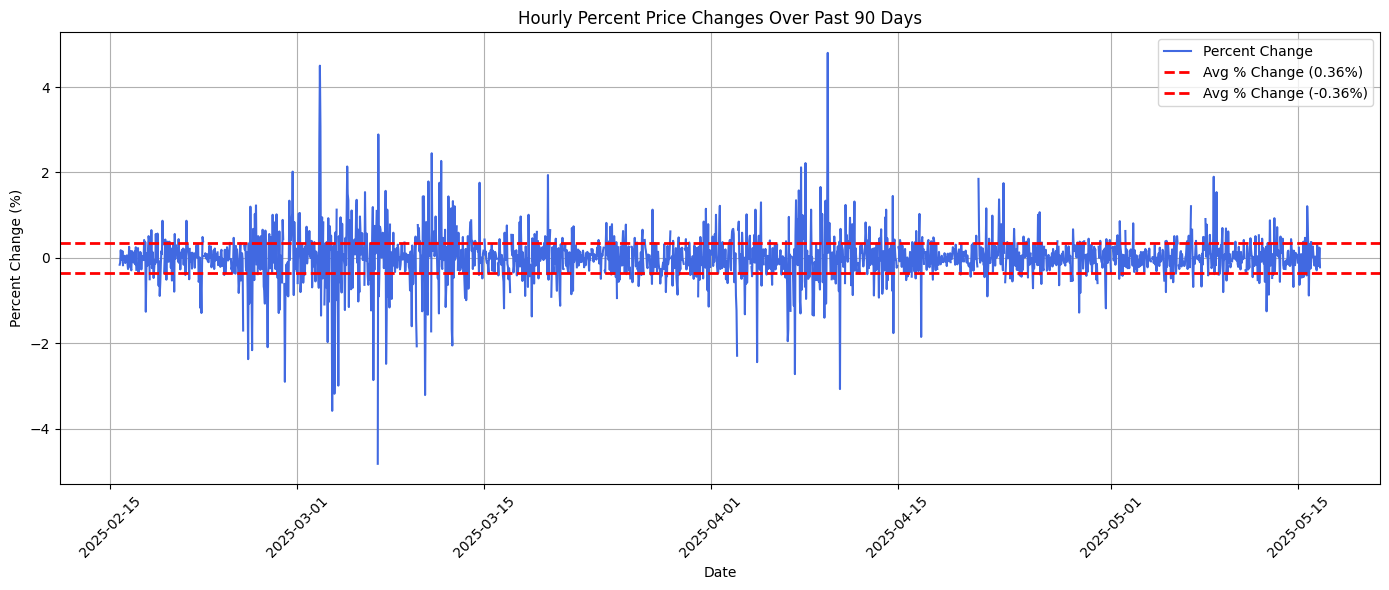

In [19]:
#Use query above, without the average where condition, to visualize the results as a line plot.
query_result = spark.sql("""
    WITH formatted_rows as(
         SELECT *, 
                DATE_FORMAT(price_date, 'yyyy-MM-dd') as date
         FROM btc_prices_hourly_auto
    ), previous_ts as (
         SELECT *, 
                LAG(price) OVER (PARTITION BY date ORDER BY price_date) as prev_price,
                LAG(price_date) OVER (PARTITION BY date ORDER BY price_date) as prev_price_date
         FROM formatted_rows
    ), price_changes as (
        SELECT *, 
               price-prev_price as price_change,
               (price-prev_price)/prev_price * 100 as percent_change
        FROM previous_ts
    ), avg_change AS (
        SELECT AVG(ABS(percent_change)) AS abs_avg_change_prcnt
        FROM price_changes
    ), final AS (
        SELECT p.*, a.abs_avg_change_prcnt
        FROM price_changes p
        CROSS JOIN avg_change a
    )
    SELECT price_date, 
           CAST(percent_change as DECIMAL(8,2)) AS percent_change, 
           CAST(abs_avg_change_prcnt as DECIMAL(8,2)) AS abs_avg_change_prcnt
    FROM final 
    ORDER BY price_date
""").toPandas()

#Convert price date and percent change to correct formats and calculate average percent change.
query_result['price_date'] = pd.to_datetime(query_result['price_date'])
query_result['percent_change'] = pd.to_numeric(query_result['percent_change'], errors='coerce')
avg_change = query_result['percent_change'].abs().mean()

plt.figure(figsize=(14, 6))
plt.plot(query_result['price_date'], query_result['percent_change'], color='royalblue', label='Percent Change', linewidth=1.5)

#Plot the positive and negative of avg_change as the change in price can be in either direction.
plt.axhline(avg_change, color='red', linestyle='--', linewidth=2, label=f'Avg % Change ({avg_change:.2f}%)')
plt.axhline(-1*avg_change, color='red', linestyle='--', linewidth=2, label=f'Avg % Change ({-1*avg_change:.2f}%)')

plt.title('Hourly Percent Price Changes Over Past 90 Days')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


## Implementing IQR on Percent Change as a Threshold 

Absolute average change results in numerous outliers (significant spikes/drops). Instead, we will consider another approach to identifying the signficant spikes and drops - Interquartile Range (IQR) method, where anything outside of the 25th and 75th percentiles is considered an outlier. In our case these outliers are significant Bitcoin (USD) spikes and drops.

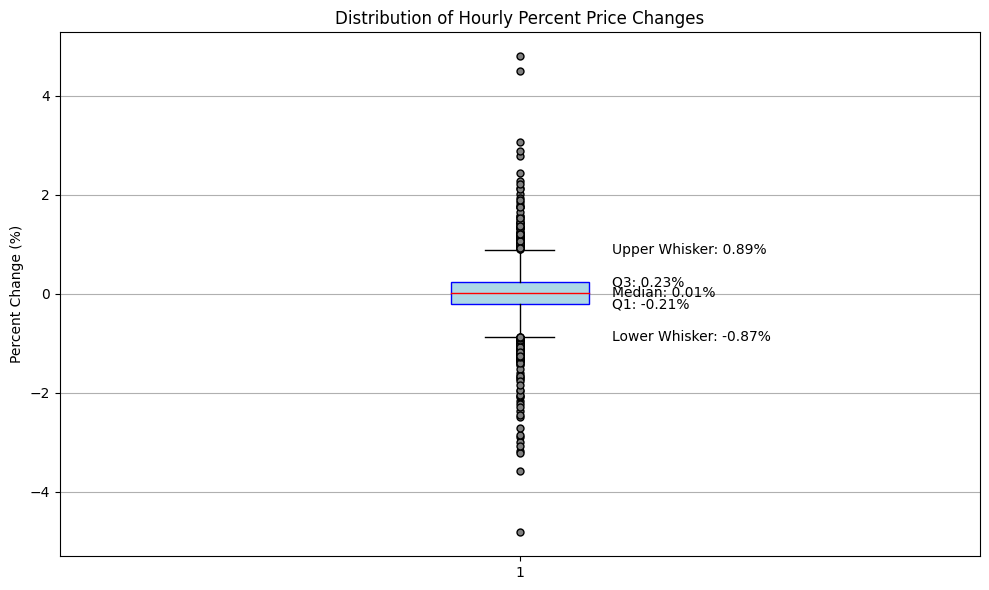

In [20]:
#Calculate the box plot statistics and display the box plot for percent change.
percent_changes = pd.to_numeric(query_result['percent_change'], errors='coerce').dropna()

Q1 = percent_changes.quantile(0.25)
Q2 = percent_changes.median()
Q3 = percent_changes.quantile(0.75)
IQR = Q3 - Q1
lower_whisker = Q1 - 1.5 * IQR
upper_whisker = Q3 + 1.5 * IQR

plt.figure(figsize=(10, 6))
plt.boxplot(percent_changes, vert=True, patch_artist=True,
            boxprops=dict(facecolor='lightblue', color='blue'),
            medianprops=dict(color='red'),
            flierprops=dict(markerfacecolor='gray', markersize=5)
           )

plt.title("Distribution of Hourly Percent Price Changes")
plt.ylabel("Percent Change (%)")
plt.grid(axis='y')

plt.text(1.1, Q1, f"Q1: {Q1:.2f}%", va='center')
plt.text(1.1, Q2, f"Median: {Q2:.2f}%", va='center')
plt.text(1.1, Q3, f"Q3: {Q3:.2f}%", va='center')
plt.text(1.1, lower_whisker, f"Lower Whisker: {lower_whisker:.2f}%", va='center')
plt.text(1.1, upper_whisker, f"Upper Whisker: {upper_whisker:.2f}%", va='center')

plt.tight_layout()
plt.show()


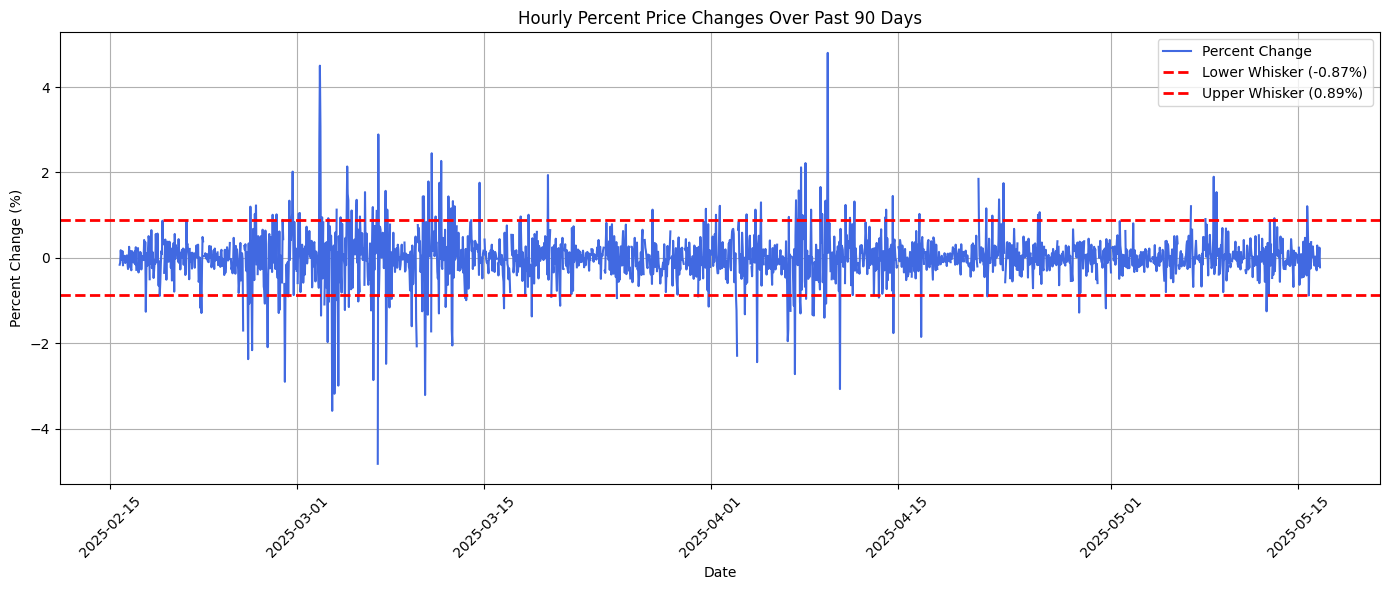

In [21]:
#Plot the same percent price changes using the query, but highlight the whisker bounds calculated above.
plt.figure(figsize=(14, 6))
plt.plot(query_result['price_date'], query_result['percent_change'], color='royalblue', label='Percent Change', linewidth=1.5)
plt.axhline(lower_whisker, color='red', linestyle='--', linewidth=2, label=f'Lower Whisker ({lower_whisker:.2f}%)')
plt.axhline(upper_whisker, color='red', linestyle='--', linewidth=2, label=f'Upper Whisker ({upper_whisker:.2f}%)')

plt.title('Hourly Percent Price Changes Over Past 90 Days')
plt.xlabel('Date')
plt.ylabel('Percent Change (%)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [22]:
#Display the price and dates that are considered as outliers using IQR.
outliers_df = query_result[
    (query_result["percent_change"] < lower_whisker) |
    (query_result["percent_change"] > upper_whisker)
]
print(outliers_df)


              price_date  percent_change abs_avg_change_prcnt
48   2025-02-17 16:03:59           -1.26                 0.36
73   2025-02-18 17:04:41           -0.89                 0.36
146  2025-02-21 18:04:42           -1.17                 0.36
148  2025-02-21 20:04:57           -1.29                 0.36
223  2025-02-24 23:04:10           -1.70                 0.36
...                  ...             ...                  ...
1972 2025-05-08 21:04:19            1.54                 0.36
2061 2025-05-12 15:04:37           -1.25                 0.36
2075 2025-05-13 05:04:52            0.93                 0.36
2134 2025-05-15 16:04:55            1.21                 0.36
2137 2025-05-15 19:03:02           -0.88                 0.36

[175 rows x 3 columns]


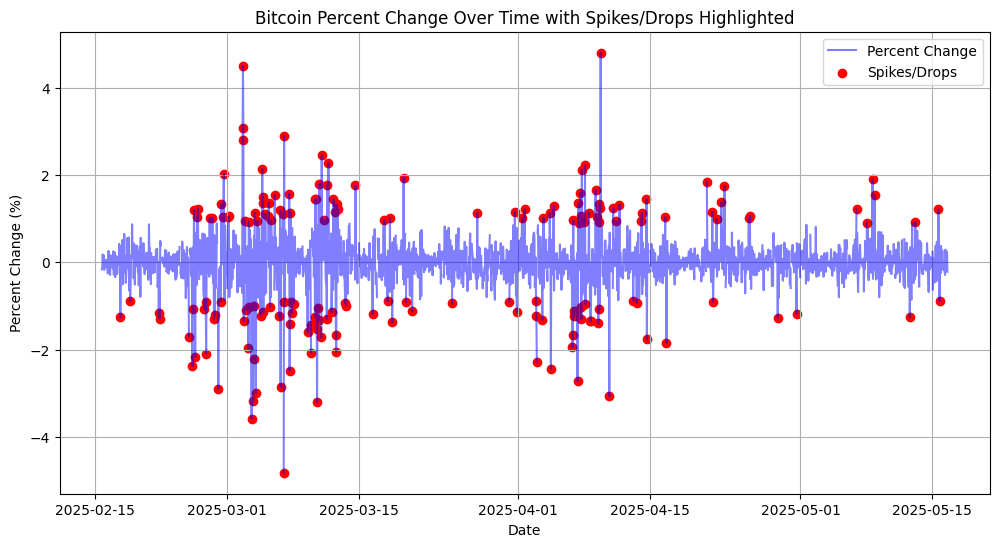

In [23]:
#Highlight those spikes and drops on the earlier figure.
plt.figure(figsize=(12, 6))
plt.plot(query_result['price_date'], query_result['percent_change'], label='Percent Change', color='blue', alpha=0.5)
plt.scatter(outliers_df['price_date'], outliers_df['percent_change'], color='red', label='Spikes/Drops')
plt.title("Bitcoin Percent Change Over Time with Spikes/Drops Highlighted")
plt.xlabel("Date")
plt.ylabel("Percent Change (%)")
plt.legend()
plt.grid(True)
plt.show()


## Further Analysis on 'Signficant' Spikes/Drops
Here, we will analyze and visualize the distribution of absolute percent changes for the significant Bitcoin price spikes and drops as identified by the IQR method (Section 6.2).

In [24]:
#Create a view with Spikes/Drops identified using IQR and assign a label of Spike or Drop.
spark.sql(f"""
    CREATE OR REPLACE TEMP VIEW spikes_drops_vw AS
    SELECT *
    FROM (
        WITH formatted_rows AS (
            SELECT *, DATE_FORMAT(price_date, 'yyyy-MM-dd') AS date
            FROM btc_prices_hourly_auto
        ), previous_ts AS (
            SELECT *, 
                   LAG(price) OVER (PARTITION BY date ORDER BY price_date) AS prev_price,
                   LAG(price_date) OVER (PARTITION BY date ORDER BY price_date) AS prev_price_date
            FROM formatted_rows
        ), price_changes AS (
            SELECT *, 
                   price - prev_price AS price_change,
                   (price - prev_price) / prev_price * 100 AS percent_change
            FROM previous_ts
        )
        SELECT price_date, 
               CAST(price AS DECIMAL(10,2)) AS price, 
               prev_price_date, 
               CAST(prev_price AS DECIMAL(10,2)) AS prev_price, 
               CAST(price_change AS DECIMAL(8,2)) AS price_change, 
               CAST(percent_change AS DECIMAL(8,2)) AS percent_change, 
               CASE WHEN percent_change < 0 THEN 'DROP' ELSE 'SPIKE' END AS category
        FROM price_changes
    ) t
    WHERE ABS(percent_change) < {lower_whisker} OR ABS(percent_change) > {upper_whisker}
""")

spark.sql("SELECT * FROM spikes_drops_vw").show()

+-------------------+--------+-------------------+----------+------------+--------------+--------+
|         price_date|   price|    prev_price_date|prev_price|price_change|percent_change|category|
+-------------------+--------+-------------------+----------+------------+--------------+--------+
|2025-02-17 16:03:59|95601.77|2025-02-17 15:03:19|  96825.39|    -1223.62|         -1.26|    DROP|
|2025-02-21 18:04:42|97057.95|2025-02-21 17:04:16|  98208.05|    -1150.11|         -1.17|    DROP|
|2025-02-21 20:04:57|95188.42|2025-02-21 19:04:57|  96432.41|    -1243.98|         -1.29|    DROP|
|2025-02-24 23:04:10|92361.40|2025-02-24 22:04:58|  93954.43|    -1593.03|         -1.70|    DROP|
|2025-02-25 08:04:15|89090.97|2025-02-25 07:04:47|  91256.71|    -2165.73|         -2.37|    DROP|
|2025-02-25 10:05:57|88440.38|2025-02-25 09:01:02|  89396.74|     -956.36|         -1.07|    DROP|
|2025-02-25 12:04:46|89256.53|2025-02-25 11:04:36|  88201.34|     1055.19|          1.20|   SPIKE|
|2025-02-2

In [25]:
#Compute some statistics on the absolute percent changed grouped by spike or drop.
spark.sql("""
    SELECT category, 
           MIN(abs(percent_change)) as min_abs_pct_chng,
           MAX(abs(percent_change)) as max_abs_pct_chng,
           AVG(abs(percent_change)) as avg_abs_pct_chng,
           COUNT(*) as num
    FROM spikes_drops_vw
    GROUP BY category
""").show()

+--------+----------------+----------------+----------------+---+
|category|min_abs_pct_chng|max_abs_pct_chng|avg_abs_pct_chng|num|
+--------+----------------+----------------+----------------+---+
|    DROP|            0.90|            4.82|        1.567195| 82|
|   SPIKE|            0.90|            4.80|        1.423636| 88|
+--------+----------------+----------------+----------------+---+



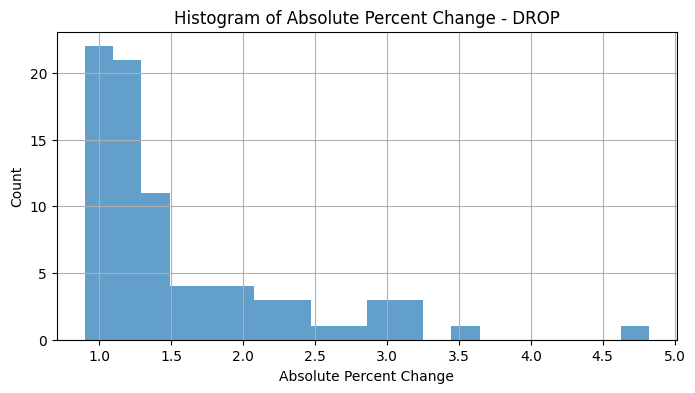

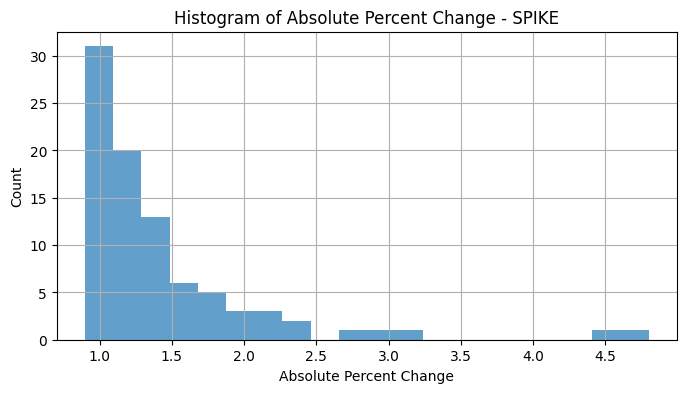

In [26]:
#Understand the distribution of the signficant price changes grouped by spike or drop.
abs_df = spark.sql("""
    SELECT category, abs(percent_change) AS abs_percent_change
    FROM spikes_drops_vw
""").toPandas()

categories = ['DROP', 'SPIKE']
for cat in categories:
    plt.figure(figsize=(8, 4))
    values = abs_df[abs_df['category'] == cat]['abs_percent_change']
    plt.hist(values, bins=20, alpha=0.7)
    plt.title(f"Histogram of Absolute Percent Change - {cat}")
    plt.xlabel("Absolute Percent Change")
    plt.ylabel("Count")
    plt.grid(True)
    plt.show()

# Price Prediction & Extrapolation
Finally, we will aim to predict and extrapolate the Bitcoin (USD) price for the next time interval at three different time intervals using the average change in price in the past. Each section looks at specific time period in the past, which can be adjusted in the aggregations and limits.

## For the next day 

This section predicts/extrapolates the price of Bitcoin (USD) for tomorrow using the last week (seven days) of price data.

In [27]:
#Display prices for the last 7 days using daily view.
spark.sql("""
    SELECT *
    FROM btc_prices
    ORDER BY price_date DESC
    LIMIT 7
""").show()

+------------------+-----------+----------+
|             price|  timestamp|price_date|
+------------------+-----------+----------+
|103708.85136423641|1.7473536E9|2025-05-16|
|103594.42575090709|1.7472672E9|2025-05-15|
|104184.49039270742|1.7471808E9|2025-05-14|
| 102876.8304286011|1.7470944E9|2025-05-13|
|  103994.061616746| 1.747008E9|2025-05-12|
| 104630.8792994166|1.7469216E9|2025-05-11|
|102962.54045692299|1.7468352E9|2025-05-10|
+------------------+-----------+----------+



In [28]:
#Calculate the average change in price over the past week, and add to yesterday's price to extrapolate tomorrow's price.
spark.sql("""
WITH past_week AS (
    SELECT *, price - LAG(price) OVER (PARTITION BY 1 ORDER BY price_date) AS price_change
    FROM btc_prices
    ORDER BY price_date DESC
    LIMIT 7
),
metrics AS (
    SELECT 
    FIRST(price) AS last_price,
    AVG(price_change) AS avg_change
    FROM past_week
)
SELECT 
    last_price + avg_change as predicted_tomorrow_price,
    last_price as yesterday_price,
    avg_change as avg_change_past_7_days,
    CASE WHEN avg_change < 0 THEN 'DECREASE' ELSE 'INCREASE' END as price_trend
FROM metrics
""").show()

+------------------------+------------------+----------------------+-----------+
|predicted_tomorrow_price|   yesterday_price|avg_change_past_7_days|price_trend|
+------------------------+------------------+----------------------+-----------+
|        103799.219336966|103708.85136423641|      90.3679727295821|   INCREASE|
+------------------------+------------------+----------------------+-----------+



In [29]:
#Using the extrapolation, union the result to exisiting data for past week and save to a dataframe.
seven_day_data = spark.sql("""
WITH past_week AS (
    SELECT *, price - LAG(price) OVER (PARTITION BY 1 ORDER BY price_date) AS price_change
    FROM btc_prices
    ORDER BY price_date DESC
    LIMIT 7
),
metrics AS (
    SELECT 
        FIRST(price_date) AS last_date,
        FIRST(price) AS last_price,
        AVG(price_change) AS avg_change
    FROM past_week
),
predicted_next_day AS (
    SELECT 
        DATE_ADD(last_date, 1) AS price_date,
        last_price + avg_change AS price
    FROM metrics
),
plot_data AS (
    SELECT price_date, price FROM past_week
    UNION ALL
    SELECT price_date, price FROM predicted_next_day
)
SELECT * FROM plot_data ORDER BY price_date
""").toPandas()

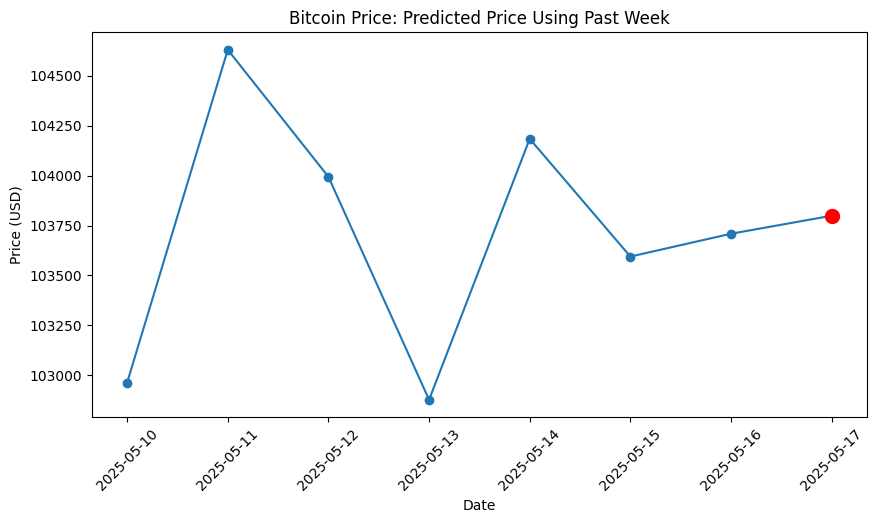

In [30]:
#Plot the past week's prices and the extrapolated price (red).
plt.figure(figsize=(10, 5))
plt.plot(seven_day_data['price_date'], seven_day_data['price'], marker='o')
plt.plot(seven_day_data['price_date'].iloc[-1], seven_day_data['price'].iloc[-1],'ro',markersize=10)
plt.xticks(rotation=45)
plt.title("Bitcoin Price: Predicted Price Using Past Week")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

## For the next month 
This section predicts/extrapolates the price of Bitcoin (USD) for the next month using the past year (12 months) of price data.

In [31]:
#Display prices for the last 12 months using daily view.
spark.sql("""
    SELECT mth_yr, AVG(price) as avg_price
    FROM (SELECT *,DATE_FORMAT(price_date, 'yyyy-MM') as mth_yr FROM btc_prices)
    GROUP BY mth_yr 
    ORDER BY mth_yr DESC
""").show()

+-------+------------------+
| mth_yr|         avg_price|
+-------+------------------+
|2025-05| 99714.74749437446|
|2025-04| 86068.12520336392|
|2025-03| 85158.74378752631|
|2025-02| 95922.84913565074|
|2025-01| 99696.06252905859|
|2024-12| 98380.90778199893|
|2024-11| 85687.36014199888|
|2024-10| 65360.04001652121|
|2024-09|60210.028723899035|
|2024-08| 60107.96853052593|
|2024-07| 62761.60804689704|
|2024-06| 66053.75856626955|
|2024-05| 68275.86396894426|
+-------+------------------+



In [32]:
#Calculate the average change in price over the past 12 months, and add to last month's avg_price to extrapolate next month's avg_price.
spark.sql("""
WITH mth_yr_price AS (
    SELECT mth_yr, AVG(price) as price
    FROM (SELECT *,DATE_FORMAT(price_date, 'yyyy-MM') as mth_yr FROM btc_prices)
    GROUP BY mth_yr 
),
past_year AS (
    SELECT *, price - LAG(price) OVER (PARTITION BY 1 ORDER BY mth_yr) AS price_change
    FROM mth_yr_price
    ORDER BY mth_yr DESC
),
metrics AS (
    SELECT 
    FIRST(price) AS last_price,
    AVG(price_change) AS avg_change
    FROM past_year
)
SELECT 
    last_price + avg_change as predicted_next_month_price,
    last_price as last_month_price,
    avg_change as avg_change_past_yr,
    CASE WHEN avg_change < 0 THEN 'DECREASE' ELSE 'INCREASE' END as price_trend
FROM metrics
""").show()

+--------------------------+-----------------+------------------+-----------+
|predicted_next_month_price| last_month_price|avg_change_past_yr|price_trend|
+--------------------------+-----------------+------------------+-----------+
|        102334.65445482697|99714.74749437446| 2619.906960452516|   INCREASE|
+--------------------------+-----------------+------------------+-----------+



In [33]:
#Using the extrapolation, union the result to exisiting data for past week and save to a dataframe.
twelve_month_df = spark.sql("""
WITH mth_yr_price AS (
    SELECT mth_yr, AVG(price) as price
    FROM (SELECT *,DATE_FORMAT(price_date, 'yyyy-MM') as mth_yr FROM btc_prices)
    GROUP BY mth_yr 
),
past_year as (
    SELECT *, price - LAG(price) OVER (PARTITION BY 1 ORDER BY mth_yr) AS price_change
    FROM mth_yr_price
    ORDER BY mth_yr DESC
),
metrics AS (
    SELECT 
        FIRST(mth_yr) AS last_date,
        FIRST(price) AS last_price,
        AVG(price_change) AS avg_change
    FROM past_year
),
predicted_next_mth AS (
    SELECT 
        DATE_FORMAT(ADD_MONTHS(last_date, 1), 'yyyy-MM') AS mth_yr,
        last_price + avg_change AS price
    FROM metrics
),
plot_data AS (
    SELECT mth_yr, price FROM past_year
    UNION ALL
    SELECT mth_yr, price FROM predicted_next_mth
)
SELECT * FROM plot_data ORDER BY mth_yr
""").toPandas()

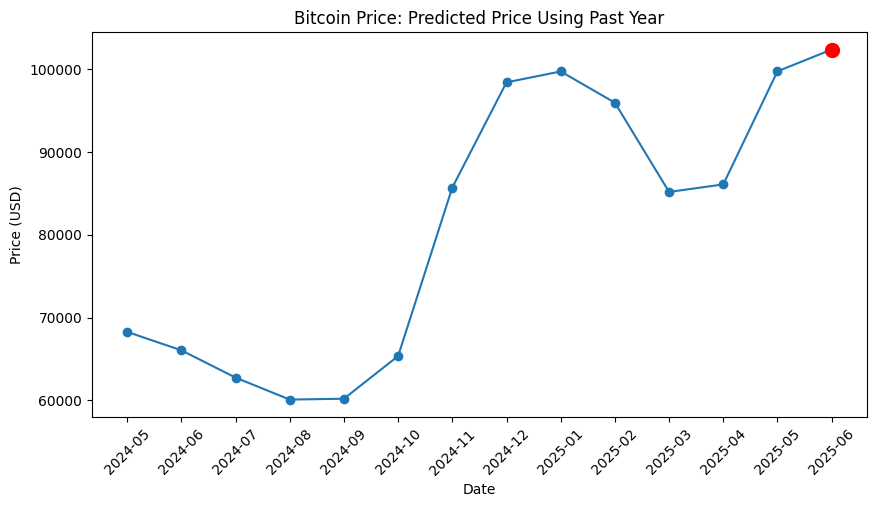

In [34]:
#Plot the past year's prices and the extrapolated price (red).
plt.figure(figsize=(10, 5))
plt.plot(twelve_month_df['mth_yr'], twelve_month_df['price'], marker='o')
plt.plot(twelve_month_df['mth_yr'].iloc[-1], twelve_month_df['price'].iloc[-1],'ro',markersize=10)
plt.xticks(rotation=45)
plt.title("Bitcoin Price: Predicted Price Using Past Year")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()

## For the next hour 
This section predicts/extrapolates the price of Bitcoin (USD) for the next hour using the last day (24 hours) of price data.

In [35]:
#Display prices for the last 24 hours using hourly view.
spark.sql("""
    SELECT *
    FROM btc_prices_hourly_auto
    ORDER BY price_date DESC
    LIMIT 24
""").show()

+------------------+----------------+-------------------+
|             price|       timestamp|         price_date|
+------------------+----------------+-------------------+
|103647.16205373578| 1.74740784187E9|2025-05-16 15:04:01|
|103878.14561854265|1.747404300515E9|2025-05-16 14:05:00|
|103626.44459045639|1.747400693085E9|2025-05-16 13:04:53|
|103672.28959796879|1.747396869062E9|2025-05-16 12:01:09|
|103870.40503140159|1.747393698896E9|2025-05-16 11:08:18|
|103745.43202947287|1.747389884423E9|2025-05-16 10:04:44|
|103448.92558696079|1.747386592578E9|2025-05-16 09:09:52|
|103754.42490400397| 1.74738283632E9|2025-05-16 08:07:16|
|103992.82840419417| 1.74737909501E9|2025-05-16 07:04:55|
|103957.37600357285|1.747375712591E9|2025-05-16 06:08:32|
| 103921.6763892081|1.747372193147E9|2025-05-16 05:09:53|
|104106.84509644518|1.747368295983E9|2025-05-16 04:04:55|
|104209.18515019871|1.747364677759E9|2025-05-16 03:04:37|
|104095.83301023155|1.747361386666E9|2025-05-16 02:09:46|
|103812.144473

In [36]:
#Calculate the average change in price over the past day, and add to latest price to extrapolate next price.
spark.sql("""
WITH past_day AS (
    SELECT *, price - LAG(price) OVER (PARTITION BY 1 ORDER BY price_date) AS price_change
    FROM btc_prices_hourly_auto
    ORDER BY price_date DESC
    LIMIT 24
),
metrics AS (
    SELECT 
    FIRST(price) AS last_price,
    AVG(price_change) AS avg_change
    FROM past_day
)
SELECT 
    last_price + avg_change as predicted_next_hr_price,
    last_price as prev_hr_price,
    avg_change as avg_change_past_24_hrs,
    CASE WHEN avg_change < 0 THEN 'DECREASE' ELSE 'INCREASE' END as price_trend
FROM metrics
""").show()

+-----------------------+------------------+----------------------+-----------+
|predicted_next_hr_price|     prev_hr_price|avg_change_past_24_hrs|price_trend|
+-----------------------+------------------+----------------------+-----------+
|     103721.90745542172|103647.16205373578|     74.74540168594406|   INCREASE|
+-----------------------+------------------+----------------------+-----------+



In [37]:
#Using the extrapolation, union the result to exisiting data for past day and save to a dataframe.
one_day_data = spark.sql("""
WITH past_day AS (
    SELECT *, price - LAG(price) OVER (PARTITION BY 1 ORDER BY price_date) AS price_change
    FROM btc_prices_hourly_auto
    ORDER BY price_date DESC
    LIMIT 24
),
metrics AS (
    SELECT 
        FIRST(price_date) AS last_date,
        FIRST(price) AS last_price,
        AVG(price_change) AS avg_change
    FROM past_day
),
predicted_next_hr AS (
    SELECT 
        last_date + INTERVAL 1 HOUR AS price_date,
        last_price + avg_change AS price
    FROM metrics
),
plot_data AS (
    SELECT DATE_TRUNC('HOUR', price_date) as price_date, price FROM past_day
    UNION ALL
    SELECT DATE_TRUNC('HOUR', price_date) as price_date, price FROM predicted_next_hr
)
SELECT * FROM plot_data ORDER BY price_date DESC
""")

one_day_data = one_day_data.withColumn("price_date", F.col("price_date").cast("string"))
one_day_data = one_day_data.toPandas()
one_day_data = one_day_data.sort_values(by='price_date', ascending=True)


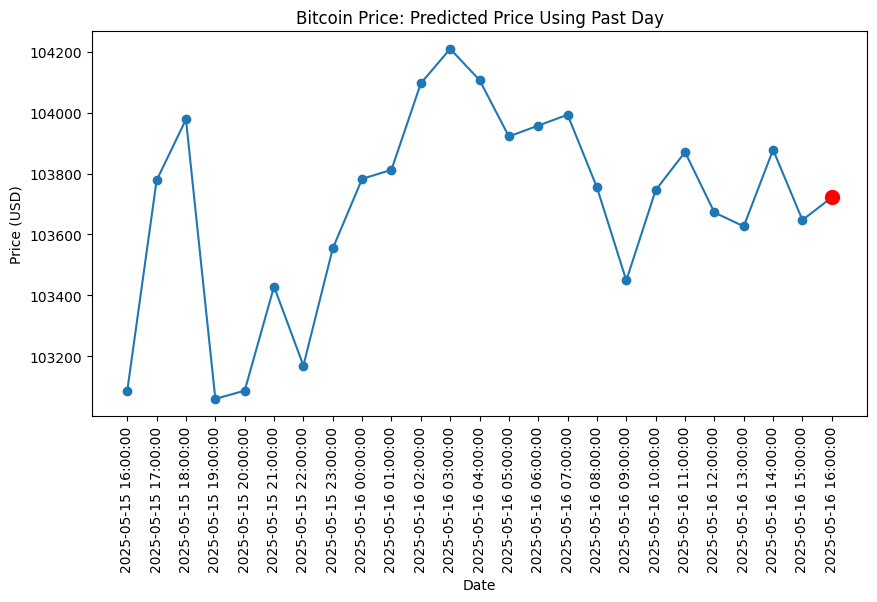

In [38]:
#Plot the past week's prices and the extrapolated price (red).
plt.figure(figsize=(10, 5))
plt.plot(one_day_data['price_date'], one_day_data['price'], marker='o')
plt.plot(one_day_data['price_date'].iloc[-1], one_day_data['price'].iloc[-1],'ro',markersize=10)
plt.xticks(rotation=90)
plt.title("Bitcoin Price: Predicted Price Using Past Day")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.show()